In [ ]:
%matplotlib inline
import os
import sys
import matplotlib.pyplot as plt 
import numpy as np
os.environ["KERAS_BACKEND"] = "tensorflow"

from tqdm import tqdm
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
#from keras import initializations
from keras import initializers

K.set_image_dim_ordering('th')



In [2]:
# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)
# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100  

In [3]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

In [ ]:
X_train.shape

In [4]:
# Function for initializing network weights
def initNormal(shape, name=None):
    #return initializations.normal(shape, scale=0.02, name=name)
    return initializers.normal(shape,scale=0.02,name=name)
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

In [5]:
# Generator
generator = Sequential()
#generator.add(Dense(128*7*7, input_dim=randomDim, init=initNormal))
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer='glorot_uniform'))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Convolution2D(64, (5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Convolution2D(1, (5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [6]:
discriminator = Sequential()
#discriminator.add(Convolution2D(64, 5, 5, border_mode='same', subsample=(2, 2), input_shape=(1, 28, 28), init=initNormal))
discriminator.add(Convolution2D(64, (5, 5), padding='same', strides=(2, 2), input_shape=(1, 28, 28), kernel_initializer='glorot_uniform'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Convolution2D(128, (5, 5), padding='same', strides=(2, 2)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [8]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
#gan = Model(input=ganInput, output=ganOutput)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)


In [9]:
dLosses = []                                                                                                                                                                     
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/dcgan_discriminator_epoch_%d.h5' % epoch)


In [10]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs: '+str(epochs))
    print('Batch size: '+str(batchSize))
    print('Batches per epoch: '+str(batchCount))

    #for e in xrange(1, epochs+1):
    for e in range(1,epochs+1):
        print('--------------- Epoch ' + str(e) + '--------------')
        #for _ in tqdm(xrange(batchCount)):
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 5 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)


  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 10
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1--------------


  1%|          | 3/468 [00:00<00:17, 26.37it/s]

--------------- Epoch 2--------------


  1%|          | 3/468 [00:00<00:17, 25.96it/s]

--------------- Epoch 3--------------


  1%|          | 3/468 [00:00<00:17, 26.36it/s]

--------------- Epoch 4--------------


  1%|          | 3/468 [00:00<00:18, 24.93it/s]

--------------- Epoch 5--------------


  1%|          | 3/468 [00:00<00:19, 23.65it/s]

--------------- Epoch 6--------------


  1%|          | 3/468 [00:00<00:21, 22.08it/s]

--------------- Epoch 7--------------


  1%|          | 3/468 [00:00<00:17, 26.43it/s]

--------------- Epoch 8--------------


  1%|          | 3/468 [00:00<00:18, 25.22it/s]

--------------- Epoch 9--------------


  1%|          | 3/468 [00:00<00:17, 25.86it/s]

--------------- Epoch 10--------------


100%|██████████| 468/468 [00:18<00:00, 25.52it/s]


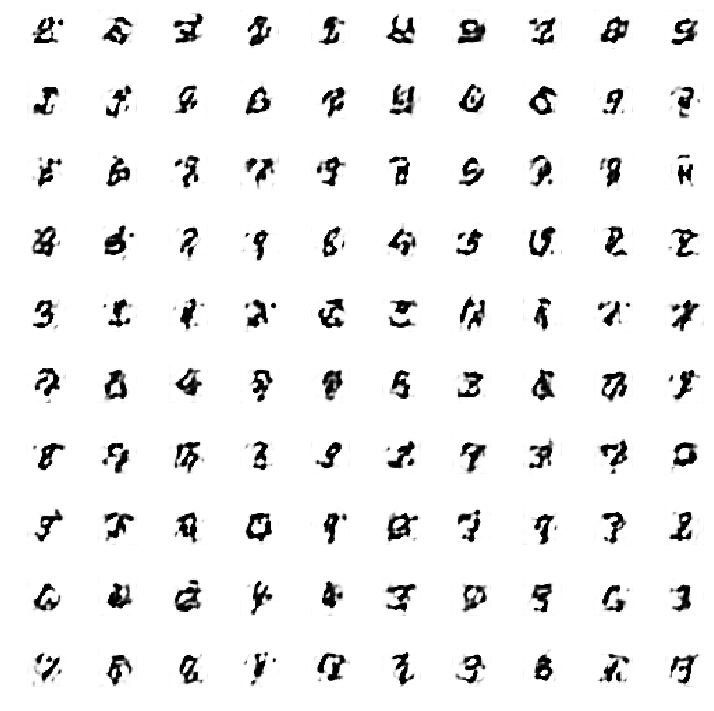

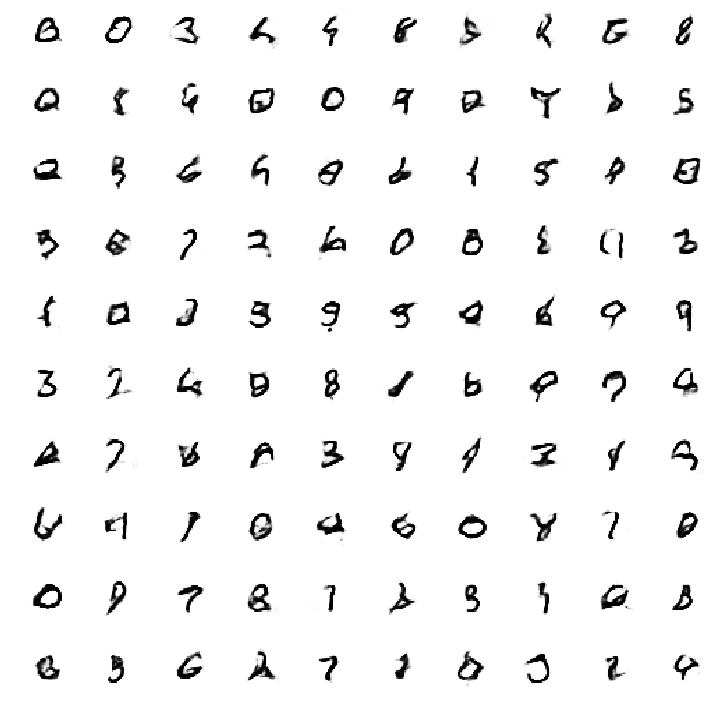

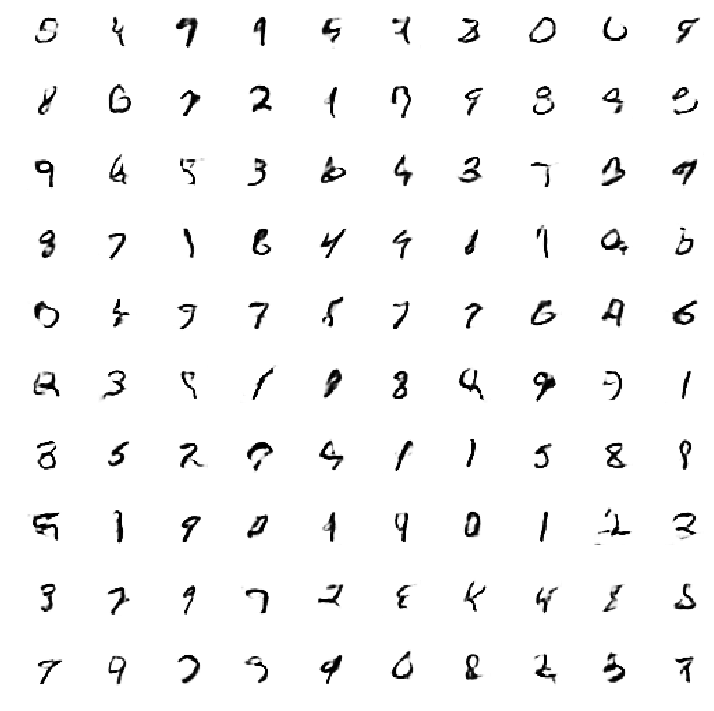

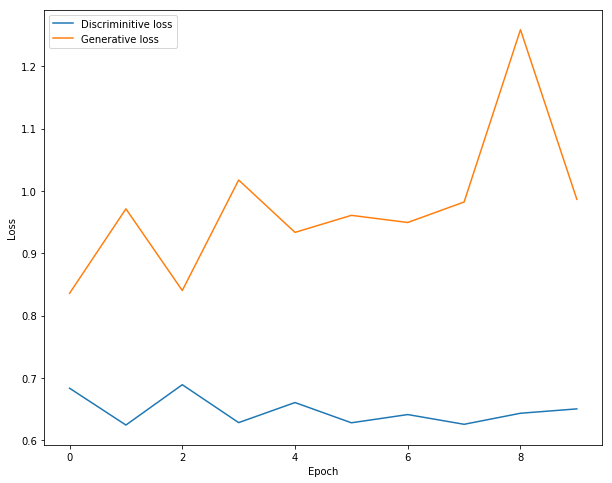

In [11]:
if __name__ == '__main__':
    train(10, 128)
                      